! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

In [205]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
import torch
import torch_scatter
import torch_sparse
#import torch_geometric
import tqdm.auto
import os
from operator import itemgetter
# import tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import regex as rex
import math

from collections import defaultdict
import matplotlib.cm as cm

import csv
import function_library_gordon_code as funclib
import cra_function_library as cralib

import ipywidgets as widget

In [207]:
#path = "/content/drive/MyDrive/output7_new_sentiment.csv"
filenm = "./output_attr_stats.csv"
# from google.colab import drive
# drive.mount('/content/drive')
#in my drive I have the csv file and I will be pulling that from my google drive

In [208]:
emails = pd.read_csv(filenm)
df = emails
#loads the emails into a pandas dataframe

In [209]:
emails1 = cralib.restructure_emails(emails)
# emails1.To is an actual list of names. Note that this cannot be saved. 

In [210]:
# emails1['ix'] is the email index, useful for future tracking
emails1.ix = emails1.index.values

In [211]:
emails1.columns

Index(['filenm', 'From', 'Sent', 'To', 'CC', 'Bcc', 'Subject', 'Attachments',
       'Importance', 'isThread', 'isAutoMessage', 'isDisplacement',
       'hasAllCapLine', 'hasBadDate', 'Body', 'timestamp', 'date_sent',
       'time_sent', 'cc', 'nb_words', 'nb_chars', 'body_len', 'body',
       'mn_nb_words', 'std_nb_words', 'mn_nb_chars', 'std_nb_chars',
       'email_count', 'ix', 'nb_to', 'nb_cc'],
      dtype='object')

In [215]:
emails1.groupby('nb_to').size()

nb_to
0       7315
1      20031
2       3318
3       1200
4        648
       ...  
471        1
479        1
489        5
526        1
618        1
Length: 116, dtype: int64

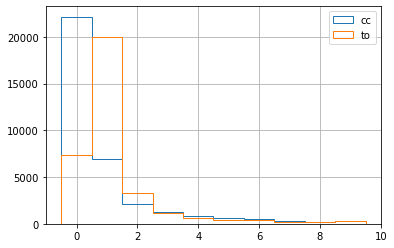

In [217]:
mx = 10
plt.grid(True)
plt.hist(emails1.nb_cc, range=[0,mx], align='left', bins=mx, histtype='step', rwidth=.1, label='cc');
plt.hist(emails1.nb_to, range=[0,mx], align='left', bins=mx, histtype='step', rwidth=.1, label='to');
plt.legend()

In [218]:
dates = df['date_sent'].values
count_not_string = 0
valid_dates = []

for date in dates:
    try:
        if not rex.match(r'.*20', date):
            print(date)
        else:
            valid_dates.append(date)
    except:
        count_not_string += 1

print("nb non-strings: ", count_not_string)
np.savetxt("valid_dates", sorted(valid_dates), fmt='%s')

# We find 585 records where the Sent field is not a string. 

nb non-strings:  585


In [219]:
emails['Sent'].isnull().sum()

277

In [220]:
df[(df['date_sent'] < '2008') | (df['date_sent'] > '2018')].date_sent

Series([], Name: date_sent, dtype: object)

In [221]:
# Save output for a single month
dct = funclib.dict_month_year(emails)

nb_rows = 0      
for k,v in list(dct.items())[0:10]:
    nb_rows += v.shape[0]
    print(k, v.shape)
    
print("tot_nb_rows: ", nb_rows)
print("emails.shape: ", emails.shape)
dct['2013','04'].to_csv("2013-04.csv", index=0)

('2008', '01') (0, 28)
('2008', '02') (0, 28)
('2008', '03') (0, 28)
('2008', '04') (0, 28)
('2008', '05') (0, 28)
('2008', '06') (0, 28)
('2008', '07') (0, 28)
('2008', '08') (4, 28)
('2008', '09') (0, 28)
('2008', '10') (0, 28)
tot_nb_rows:  4
emails.shape:  (35942, 28)


In [222]:
emails.shape

(35942, 28)

### Nodes should be people defined by From, CC, To

In [224]:
nodes_2011_08 = funclib.get_unique_nodes_ge(df)

df:  (35942, 28)
sender_list:  1836
cc_receiver_list:  3531
to_receiver_list:  11323
node_list:  14075
in cc but not in sender = cc - sender:  3000
in to but not in sender = to - sender:  10480


In [225]:
#Found the following emails that need fixing: 
"""
heperez<heperez@earthlink.net%3cmailto:heperez><heperez@earthlink.net%3cmailto:heperez
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
jay.tallahasseedowntown=gmail.com@mail129.us2.mcsv.net
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
jay.tallahasseedowntown=gmail.com@mail121.us2.mcsv.net
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
jay.tallahasseedowntown=gmail.com@mail21.wdc03.rsgsv.net
heperez<heperez@earthlink.net%3cmailto:heperez><heperez@earthlink.net%3cmailto:heperez
jay.tallahasseedowntown=gmail.com@mail66.atl11.rsgsv.net
jay.tallahasseedowntown=gmail.com@mail181.wdc02.mcdlv.net
jay.tallahasseedowntown=gmail.com@mail205.atl81.rsgsv.net
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
jay.tallahasseedowntown=gmail.com@mail21.wdc03.rsgsv.net
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
jay.tallahasseedowntown=gmail.com@mail180.wdc02.mcdlv.net
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
jay.tallahasseedowntown=gmail.com@mail21.wdc03.rsgsv.net
jay.tallahasseedowntown=gmail.com@mail26.wdc03.rsgsv.net
jay.tallahasseedowntown=gmail.com@mail26.wdc03.rsgsv.net
jay.tallahasseedowntown=gmail.com@mail28.wdc03.rsgsv.net
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
jay.tallahasseedowntown=gmail.com@mail25.wdc03.rsgsv.net
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
invitation.miami-cslt-owner@liste.diplomatie.gouv.fr
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
heperez<heperez@earthlink.net%3cmailto:heperez><heperez@earthlink.net%3cmailto:heperez
jay.tallahasseedowntown=gmail.com@mail66.atl11.rsgsv.net
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
microsoftexchange329e71ec88ae4615bbc36ab6ce41109e@talgov.com
jay.tallahasseedowntown=gmail.com@mail24.wdc03.rsgsv.net
jay.tallahasseedowntown=gmail.com@mail24.wdc03.rsgsv.net
jay.tallahasseedowntown=gmail.com@mail26.wdc03.rsgsv.net
jay.tallahasseedowntown=gmail.com@mail174.us4.mcsv.net
patrickmckee@mindspring.com%3cpatrickmckee@mindspring.com>
850)545-2095edward.kring@talgov.comsentfrommyiphonethanks,eddieedwardmarwkringci-zenengagementambassador,departmentofcommunica-onsoﬃce:(850)891-8081cell:(850
850)545-2095edward.kring@talgov.comsentfrommyiphonethanks,eddieedwardmarwkringci-zenengagementambassador,departmentofcommunica-onsoﬃce:(850)891-8081cell:(850
downtown_colleagues@mailman.downtowndevelopment.com
downtown_colleagues@mailman.downtowndevelopment.com
downtown_colleagues@mailman.downtowndevelopment.com

Remove .*smtp:  prefix in mails
 'heperez<heperez@earthlink.net%3cmailto:heperez',
 'heperez<heperez@earthlink.net%3cmailto:heperez><heperez@earthlink.net%3cmailto:heperez',
""";

In [230]:
len(emails1.From), len(set(emails1.From))
# There are 35,942 emails sent (with 570 emails without Sent information). But only 3172 different senders. 

(35942, 3172)

In [468]:
# print(all_nodes)

In [473]:
## Remove Outliers

## Rescale attributers to satisfy N(0,1)

In [233]:
# First remove outliers. Will do that at a later time.
# Rescale with respect to all the emails I am considering (training + testing)
# I should keep track of scaling parameters because if I add new testing data, I will
# have to rescale.
# print(tab)

b = emails1.copy()
all_emails1 = funclib.remove_outliers(b, nb_std=3)
all_emails1.describe().transpose()

max nb words:  94406.0 94406
max nb chars:  530506.0 530506
max nb words:  973
max nb chars:  5335
maxw, maxc:  973.0 5335.0
max nb words:  1.0
max nb chars:  1.0


/Users/erlebach/src/2022/CRA_network/gordon_graph_email_modeling/function_library_gordon_code.py:1516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for epoch in range(nb_epochs):
/Users/erlebach/src/2022/CRA_network/gordon_graph_email_modeling/function_library_gordon_code.py:1517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model.train()


,count,mean,std,min,25%,50%,75%,max
Bcc,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timestamp,34814.0,1.402763e+09,1.871570e+08,-1.000000,1.372782e+09,1.427112e+09,1.475490e+09,1.506532e+09
nb_words,34814.0,1.411590e-01,1.538775e-01,0.001028,3.905447e-02,9.146968e-02,1.839671e-01,1.000000e+00
nb_chars,34814.0,1.431471e-01,1.519492e-01,0.000000,3.973758e-02,9.315839e-02,1.955014e-01,1.000000e+00
body_len,34814.0,9.000376e+02,9.562800e+02,0.000000,2.490000e+02,5.910000e+02,1.216000e+03,6.282000e+03
mn_nb_words,34814.0,2.264047e+02,4.540815e+02,1.000000,9.667500e+01,1.549065e+02,2.214232e+02,1.911150e+04
std_nb_words,33628.0,4.448986e+02,1.112533e+03,0.000000,7.801866e+01,1.315201e+02,2.927422e+02,3.574130e+04
mn_nb_chars,34814.0,1.247290e+03,2.540314e+03,0.000000,5.102703e+02,7.990565e+02,1.288859e+03,1.075082e+05
std_nb_chars,33628.0,2.341982e+03,5.974232e+03,0.000000,4.260475e+02,6.902488e+02,1.754830e+03,2.007386e+05
email_count,34814.0,4.441725e+02,8.340943e+02,1.000000,1.900000e+01,9.000000e+01,4.290000e+02,3.030000e+03


### all_emails.columns

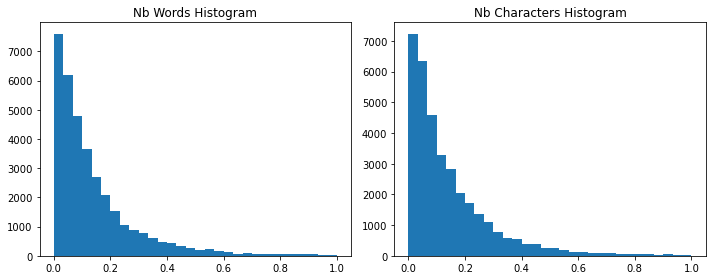

In [234]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(all_emails1.nb_words, bins=30);
plt.title("Nb Words Histogram")
plt.subplot(1,2,2)
plt.hist(all_emails1.nb_chars, bins=30);
plt.title("Nb Characters Histogram")
plt.tight_layout()

# Create nodes and edges

In [241]:
edges, index_values = funclib.make_edges_ge(emails1, keep_only_emails=True, headers_as_list=True)

In [242]:
all_emails1.shape, len(index_values), emails.shape

((34814, 31), 14899, (35942, 28))

In [245]:
all_emails2 = all_emails1.loc[index_values,:]
#all_emails2.shape, len(all_nodes)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([32799, 32823, 32969, 33007,   262,\n            ...\n            32540, 32636, 32671, 32704, 32754],\n           dtype='int64', length=461). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [550]:
# Only 1836 different nodes have edges. That is hard to believe. I expected 3172. 
# This implies that 3172-1836 = 1000+164+72 = 1,236 nodes have no To: and no CC: . 
# What this means is that 1,236 nodes have no edges to nodes with corresponding emails. That 
#   is believable. As a check I changed the argument keep_only_emails to False and get 3171 nodes
# with edges. I expected 3172, but off by 1 is good. However, it does indicate an error somewhere.
len(edges)

9885

In [551]:
edges[0:10]

[['8503397879@mms.att.net', 'jt@inkbridge.com'],
 ['8505102520@vzwpix.com', '8505562328@vzwpix.com'],
 ['8505102520@vzwpix.com', '8505096399@icmms1.sun5.lightsurf.net'],
 ['8505102520@vzwpix.com', 'gary@govinc.net'],
 ['8505102520@vzwpix.com', '8505449269@vzwpix.com'],
 ['8505102520@vzwpix.com', 'gil.ziffer@talgov.com'],
 ['8505102520@vzwpix.com', '8505096463@vzwpix.com'],
 ['8505102520@vzwpix.com', 'gail@ziffberry.com'],
 ['@comcast.net', 'jcall@tallahassee.com'],
 ['@comcast.net', 'lpiss@miamiherald.com']]

In [554]:
# Saving edges, methods 1 and 2
np.savetxt("edges.txt", all_edges, fmt="%s", header='node1, node2')
edgesT = np.asarray(all_edges).transpose()
ddf = pd.DataFrame({'node1':edgesT[0], 'node2':edgesT[1]})
ddf.to_csv('edges.txt', index=0)
# Generates the same file as with savetxt without the comment in the first line

In [557]:
# Saving edges, method 3
edges_df = pd.DataFrame(data=all_edges, columns=['node1', 'node2'])
edges_df.to_csv('edges1.txt', index=0)
# Same result

nodes_df = pd.DataFrame({'nodes':all_nodes})
nodes_df.to_csv('nodes.txt', index=0)

# Groupby user

In [347]:
emailsg = all_emails2.groupby('From').agg(['mean','median','std','count'])
emailsg_cols = emailsg[[('nb_words','median'),('nb_words','mean'),('nb_words','std'),('nb_chars','median'),('nb_chars','mean'),('nb_chars', 'std'),('nb_chars','count')]]

In [203]:
# std is zero if only a single email. So replace NaN by zero
emailsg_cols = emailsg_cols.fillna(0)
emailsg_cols.columns = ['median_words','mean_words','std_words','median_chars','mean_chars','std_chars','count']
emailsg_cols.head(5)

NameError: name 'emailsg_cols' is not defined

In [345]:
emailsg

Bcc                   isThread                  \
                            mean median std count      mean median      std   
From                                                                          
.williams@talgov.com         NaN    NaN NaN     0  0.000000    0.0      NaN   
8503397879@mms.att.net       NaN    NaN NaN     0  0.000000    0.0  0.00000   
8503635629@vzwpix.com        NaN    NaN NaN     0  0.000000    0.0      NaN   
8505102520@vzwpix.com        NaN    NaN NaN     0  0.000000    0.0      NaN   
@comcast.net                 NaN    NaN NaN     0  0.333333    0.0  0.57735   
...                          ...    ...  ..   ...       ...    ...      ...   
yourownutilities@talgov.com  NaN    NaN NaN     0  0.000000    0.0  0.00000   
yulonda.mitchell@talgov.com  NaN    NaN NaN     0  0.000000    0.0  0.00000   
ywang@thf-cpa.com            NaN    NaN NaN     0  0.000000    0.0  0.00000   
zachary.galloway@talgov.com  NaN    NaN NaN     0  0.000000    0.0      NaN   
zachary.lyne@talgov.com      NaN    NaN NaN     0  0.000000    0.0      NaN   

                                  isAutoMessage         ... mn_nb_chars        \
                            count          mean median  ...         std count   
From                                                    ...                     
.williams@talgov.com            1      0.000000    0.0  ...         NaN     1   
8503397879@mms.att.net          2      0.000000    0.0  ...         0.0     2   
8503635629@vzwpix.com           1      0.000000    0.0  ...         NaN     1   
8505102520@vzwpix.com           1      0.000000    0.0  ...         NaN     1   
@comcast.net                    3      0.000000    0.0  ...         0.0     3   
...                           ...           ...    ...  ...         ...   ...   
yourownutilities@talgov.com    28      0.000000    0.0  ...         0.0    28   
yulonda.mitchell@talgov.com     3      0.333333    0.0  ...         0.0     3   
ywang@thf-cpa.com               2      0.000000    0.0  ...         0.0     2   
zachary.galloway@talgov.com     1      0.000000    0.0  ...         NaN     1   
zachary.lyne@talgov.com         1      0.000000    0.0  ...         NaN     1   

                            std_nb_chars                         email_count  \
                                    mean       median  std count        mean   
From                                                                           
.williams@talgov.com                 NaN          NaN  NaN     0           1   
8503397879@mms.att.net         21.920310    21.920310  0.0     2           2   
8503635629@vzwpix.com                NaN          NaN  NaN     0           1   
8505102520@vzwpix.com                NaN          NaN  NaN     0           1   
@comcast.net                 1239.300340  1239.300340  0.0     3           3   
...                                  ...          ...  ...   ...         ...   
yourownutilities@talgov.com   174.921914   174.921914  0.0    28          28   
yulonda.mitchell@talgov.com   236.713610   236.713610  0.0     3           3   
ywang@thf-cpa.com              85.559921    85.559921  0.0     2           2   
zachary.galloway@talgov.com          NaN          NaN  NaN     0           1   
zachary.lyne@talgov.com              NaN          NaN  NaN     0           1   

                                               
                            median  std count  
From                                           
.williams@talgov.com             1  NaN     1  
8503397879@mms.att.net           2  0.0     2  
8503635629@vzwpix.com            1  NaN     1  
8505102520@vzwpix.com            1  NaN     1  
@comcast.net                     3  0.0     3  
...                            ...  ...   ...  
yourownutilities@talgov.com     28  0.0    28  
yulonda.mitchell@talgov.com      3  0.0     3  
ywang@thf-cpa.com                2  0.0     2  
zachary.galloway@talgov.com      1  NaN     1  
zachary.lyne@talgov.com          1  NaN   

# Integrate stats back into the email file

In [355]:
all_emails.columns

Index(['filenm', 'From', 'Sent', 'To', 'CC', 'Bcc', 'Subject', 'Attachments',
       'Importance', 'isThread', 'isAutoMessage', 'isDisplacement',
       'hasAllCapLine', 'hasBadDate', 'Body', 'timestamp', 'date_sent',
       'time_sent', 'cc', 'nb_words', 'nb_chars', 'body_len', 'body',
       'mn_nb_words', 'std_nb_words', 'mn_nb_chars', 'std_nb_chars',
       'email_count'],
      dtype='object')

In [198]:
all_emails3 = cralib.integrate_stats_back_into_emails(all_emails2)
len(all_emails3)

NameError: name 'all_emails2' is not defined

# Draw the graph

In [598]:
all_nodes = funclib.get_Unique_Nodes(all_emails3, verbose=False, keep_only_emails=True)
#generates the nodes that were used in 2011/08 and all of the nodes in the dataset
len(all_nodes), len(set(all_nodes))

(5405, 5405)

In [610]:


df, nodes, edges = funclib.create_nodes_edges_ge(all_emails3, keep_only_emails=True)
funclib.save_nodes_edges(nodes, edges, node_file="nodes.txt", edge_file="edges.txt")


In [646]:
df.columns

Index(['filenm', 'From', 'Sent', 'To', 'CC', 'Bcc', 'Subject', 'Attachments',
       'Importance', 'isThread', 'isAutoMessage', 'isDisplacement',
       'hasAllCapLine', 'hasBadDate', 'Body', 'timestamp', 'date_sent',
       'time_sent', 'cc', 'nb_words', 'nb_chars', 'body_len', 'body',
       'mn_nb_words', 'std_nb_words', 'mn_nb_chars', 'std_nb_chars',
       'email_count', 'med_nb_words', 'med_nb_chars', 'email_countxx'],
      dtype='object')

In [599]:
dct_month_year = funclib.dict_month_year(df)

In [625]:
month_df = dct_month_year['2013', '03']
df, nodes_df, edges_df = funclib.create_nodes_edges_ge(month_df, keep_only_emails=True)

In [648]:
len(nodes_df), len(edges_df)
len(G.nodes)

69

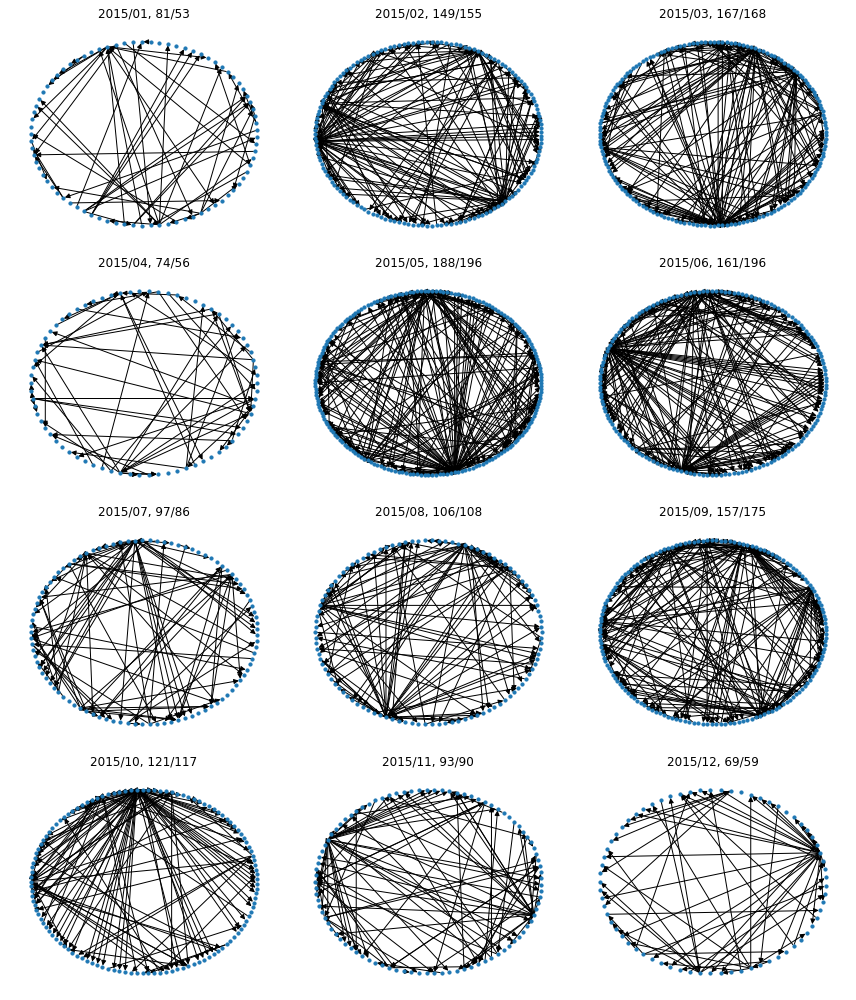

In [766]:
funclib.plot_emails_one_year(dct_month_year, '2015')

In [770]:
month_df[['From','mn_nb_chars']]

,From,mn_nb_chars
32937,dwayne.snyder@talgov.com,0.029827
32988,sab_staff.epadom@epamail.epa.gov,0.230185
508,acorey@101tally.com,0.142112
33346,patricia.mccray@talgov.com,0.183486
922,patricia.mccray@talgov.com,0.183486
...,...,...
31370,patricia.mccray@talgov.com,0.183486
32006,acorey@101tally.com,0.142112
32326,gary@zprgroup.com,0.166032
32529,clscraigstevens@earthlink.net,0.237142


In [202]:
G = nx.DiGraph()
month_df = dct_month_year['2015', '12']
print("month_df.shape: ", month_df.shape)
df, nodes, edges = funclib.create_nodes_edges_ge(month_df, keep_only_emails=True)
G.add_nodes_from(nodes)
G.add_edges_from(edges)
len(nodes), len(edges), df.shape

NameError: name 'dct_month_year' is not defined

In [201]:
cralib.add_features(G, month_df)
G = cralib.convert_nodes_to_ints(G)
len(G.nodes()), len(G.edges())

NameError: name 'month_df' is not defined

In [794]:
month_df.shape, len(nodes)

((104, 31), 165)

In [779]:
cralib.update_associated_matrices(G)

torch.Size([69, 69]) torch.Size([69, 69])
G.B:  torch.Size([59, 69]) G.B.transp:  torch.Size([69, 59])


/Users/erlebach/src/2022/CRA_network/gordon_graph_email_modeling/cra_function_library.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  G.An = torch.tensor(G.Dinvsq @ G.An @ G.Dinvsq).float() # symmetric normalization


In [785]:
cralib.add_features(G, month_df)

(104, 4)


In [784]:
G.nb_nodes, G.nb_edges

(69, 59)

In [783]:
cralib.plot_metadata(G)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 69 but corresponding boolean dimension is 104

In [774]:
# all_emails are all the email records that correspond to the graph
# Aggregate the number of characters pdf 

# Handle node attributes
* Find all the emails from  the network. To do this, find all the loc of the emails database. 

In [275]:
emails.columns

Index(['filenm', 'From', 'Sent', 'To', 'CC', 'Bcc', 'Subject', 'Attachments',
       'Importance', 'isThread', 'isAutoMessage', 'isDisplacement',
       'hasAllCapLine', 'hasBadDate', 'Body', 'timestamp', 'date_sent',
       'time_sent', 'cc', 'nb_words', 'nb_chars', 'body_len', 'body',
       'mn_nb_words', 'std_nb_words', 'mn_nb_chars', 'std_nb_chars',
       'email_count'],
      dtype='object')

## Reanalyze standardization of 
* 23333_fn_34-2-ScottMaddox2_ln_108763.txt
    * The 'To' field becomes 'n', the CC field becomes invalid_nan. Something wrong? 

# strange emails
 '850)545-2095edward.kring@talgov.comsentfrommyiphonethanks,eddieedwardmarwkringci-zenengagementambassador,departmentofcommunica-onsoﬃce:(850)891-8081cell:(850',
 '[smtp:silam@earthlink.net',

In [ ]:
all_2012_graph = Graph()
all_2012_graph.read_edges('edges.txt')
all_2012_graph.read_node_metadata('nodes.txt')

In [ ]:
model = Simple_GNN(16,64,8133,3,aggregation_mode='mean')

display((all_2012_graph.node_metadata).shape)

### We initialize the GNN_Trainer and train for 200
### epochs on CPU. 
trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
#display(model)
predictions = trainer(model)

In [ ]:
display(edge_2011_08)
get_sent_list(edge_2011_08, len(nodes_2011_08))
sent_2012 = get_sent_list(edges_2012, len(nodes_2012))

In [ ]:
recieved_2012 = get_recieved_list(edges_2012, len(nodes_2012))

In [ ]:
node_num_2012 = []
for node in nodes_2012:
  x = nodes_2012.index(node)
  node_num_2012.append(x)
node_meta_2012 = [node_num_2012, sent_2012, recieved_2012]
display(len(node_meta_2012))
create_nodes_txt(node_meta_2012)

In [ ]:
all_2012_graph = Graph()
all_2012_graph.read_edges('edges.txt')
all_2012_graph.read_node_metadata('nodes.txt')

In [ ]:
model = Simple_GNN(2,64,5958,3,aggregation_mode='mean')

display((all_2012_graph.node_metadata).shape)

### We initialize the GNN_Trainer and train for 200
### epochs on CPU. 
trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
#display(model)
predictions = trainer(model)

In [ ]:
email_node_meta_2012 = get_email_node_meta(all_2012)

In [ ]:
email_edge_2012 = create_email_edgelist(all_2012, nodes_2012)

In [ ]:
email_G = nx.Graph()
email_nodes_2012 = []
for i in range(len(all_2012)):
  email_nodes_2012.append(i)
email_G.add_nodes_from(email_nodes_2012)
email_G.add_edges_from(email_edge_2012)
for i in range(len(all_2012)):
  email_G.nodes[i]['num char'] = email_node_meta_2012[0][i]
  email_G.nodes[i]['num word'] = email_node_meta_2012[1][i]
  email_G.nodes[i]['mean char in word'] = email_node_meta_2012[2][i]
  email_G.nodes[i]['std char in word'] = email_node_meta_2012[3][i]

email_G.nodes.data()

In [ ]:
test_node_11_08 = create_node_list(emails_2011_08)
display(test_node_11_08)

In [ ]:
test_edge_11_08 = create_edge_list(emails_2011_08, test_node_11_08)
display(test_edge_11_08)

In [ ]:
test_node_2012_01 = create_node_list(month_2012[0])
test_edge_2012_01 = create_edge_list(month_2012[0], test_node_2012_01)

display(test_node_2012_01)
display(test_edge_2012_01)

In [ ]:
x = []
display(len(x))

In [ ]:
rec_node_list = get_node_recieved_list(month_2012[0], test_node_2012_01)
display(rec_node_list)

In [ ]:
test_node_meta_2012_01 = create_node_meta_list(month_2012[0], test_node_2012_01)
display(test_node_meta_2012_01)

In [ ]:
create_edge_meta_list(month_2012[0], test_node_2012_01, test_edge_2012_01)

In [ ]:
node_list_2012 = create_node_list(all_2012)
edge_list_2012 = create_edge_list(all_2012, node_list_2012)
node_meta_list_2012 = create_node_meta_list(all_2012, node_list_2012)
rec_node_list_2012 = get_node_recieved_list(all_2012, node_list_2012)

In [ ]:
bi_class_to_2012 = create_bi_class_to(all_2012, node_meta_list_2012)

In [ ]:
#later create a more optimized way of seperating the node metadata
char_mean_2012 = []
word_mean_2012 = []
to_mean_2012 = []
cc_mean_2012 = []
char_std_2012 = []
word_std_2012 = []
to_std_2012 = []
cc_std_2012 = []
num_sent_2012 = []
#rec_node_list_2012
bi_class_char_2012 = create_bi_class_char(all_2012, node_meta_list_2012)
for i in range(len(node_meta_list_2012)):
  q = node_meta_list_2012[i]
  char_mean_2012.append(q[0])
  word_mean_2012.append(q[1])
  to_mean_2012.append(q[2])
  cc_mean_2012.append(q[3])
  char_std_2012.append(q[4])
  word_std_2012.append(q[5])
  to_std_2012.append(q[6])
  cc_std_2012.append(q[7])
  num_sent_2012.append(q[8])
bi_class_list_char_mean_2012 = create_bi_class(all_2012, char_mean_2012)
bi_class_list_word_mean_2012 = create_bi_class(all_2012, word_mean_2012)
bi_class_list_to_mean_2012 = create_bi_class(all_2012, to_mean_2012)
bi_class_list_cc_mean_2012 = create_bi_class(all_2012, cc_mean_2012)
bi_class_list_char_std_2012 = create_bi_class(all_2012, char_std_2012)
bi_class_list_word_std_2012 = create_bi_class(all_2012, word_std_2012)
bi_class_list_to_std_2012 = create_bi_class(all_2012, to_mean_2012)
bi_class_list_cc_std_2012 = create_bi_class(all_2012, cc_mean_2012)
bi_class_list_num_sent_2012 = create_bi_class(all_2012, num_sent_2012)
bi_class_list_num_rec_2012 = create_bi_class(all_2012, rec_node_list_2012)
bi_classes = [bi_class_list_char_mean_2012, bi_class_list_word_mean_2012, bi_class_list_to_mean_2012, bi_class_list_cc_mean_2012, bi_class_list_char_std_2012, bi_class_list_word_std_2012, bi_class_list_to_std_2012, bi_class_list_cc_std_2012, bi_class_list_num_sent_2012, bi_class_list_num_rec_2012]
display(len(node_meta_list_2012))
display(len(node_meta_list_2012[0]))
display(node_meta_list_2012[4])

In [ ]:
#this is what generated the plots that I used in the meeting


titles = ['mean char', 'mean words', 'mean to', 'mean cc', 'std char', 'std words', 'std to', 'std cc', 'num sent', 'num recieved']
figure_title = ['mean_char.png', 'mean_words.png', 'mean_to.png', 'mean_cc.png', 'std_char.png', 'std_words.png', 'std_to.png', 'std_cc.png', 'num_sent.png', 'num_recieved.png']
for i in range(10):
  create_node_list_txt(node_list_2012, node_meta_list_2012, rec_node_list_2012, bi_classes[i])
  create_edges_txt(edge_list_2012)
  all_2012_graph = Graph()
  all_2012_graph.read_edges('edges.txt')
  all_2012_graph.read_node_metadata('nodes.txt')
  model = Simple_GNN(10,64,2,3,aggregation_mode='mean')

  display((all_2012_graph.node_metadata).shape)
  

  ### We initialize the GNN_Trainer and train for 200
  ### epochs on CPU. 
  r = torch.randperm(all_2012_graph.num_nodes)
  trainer = GNN_Node_Trainer(all_2012_graph,train_index= r[:int(.8 * len(r))], test_index= r[int(.8 * len(r))::],num_epochs=200,random_seed=1)
  #display(model)
  predictions = trainer(model)
  print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
  print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")
  acc = print_acc(predictions, bi_classes[i])
  color_str = 'rb'
  #colors = cm.rainbow(predictions.argmax(dim=1))
  predx = []
  predy = []
  prepx1 = []
  prepx2 = []
  prepy1 = []
  prepy2 = []
  for j in range(len(predictions)):
    q = torch.detach(predictions[j])
    predx.append(q[0])
    predy.append(q[1])
    if predictions.argmax(dim=1)[j] == 0:
      prepx1.append(q[0])
      prepy1.append(q[1])
    else:
      prepx2.append(q[0])
      prepy2.append(q[1])
  plt.figure()
  e = np.ones(len(predictions))#0 is purple 1 is yellow
  #plt.scatter(predx, predy, c=e)
  #plt.scatter(predx, predy, c=predictions.argmax(dim=1))
  fig, ax = plt.subplots()
  p1 = ax.scatter(prepx1, prepy1, c='blue')
  p2 = ax.scatter(prepx2, prepy2, c='red')
  s = str(acc)
  plt.title(titles[i] + ' accuraccy = ' + s[0:5] + '%')
  fig.legend((p1,p2),('less than','greater than'))
  fig.savefig(figure_title[i])
  plt.show()
  


In [ ]:
create_node_list_txt(node_list_2012, node_meta_list_2012, rec_node_list_2012, bi_class_to_2012)
create_edges_txt(edge_list_2012)


In [ ]:
all_2012_graph = Graph()
all_2012_graph.read_edges('edges.txt')
all_2012_graph.read_node_metadata('nodes.txt')
model = Simple_GNN(10,64,2,3,aggregation_mode='mean')

display((all_2012_graph.node_metadata).shape)

### We initialize the GNN_Trainer and train for 200
### epochs on CPU. 
trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
#display(model)
predictions = trainer(model)

In [ ]:
display(torch.detach(predictions[0]))

In [ ]:
create_node_list_txt(node_list_2012, node_meta_list_2012, rec_node_list_2012, bi_class_char_2012)
create_edges_txt(edge_list_2012)

In [ ]:
all_2012_graph = Graph()
all_2012_graph.read_edges('edges.txt')
all_2012_graph.read_node_metadata('nodes.txt')
model = Simple_GNN(10,64,2,3,aggregation_mode='mean')

display((all_2012_graph.node_metadata).shape)

### We initialize the GNN_Trainer and train for 200
### epochs on CPU. 
trainer = GNN_Node_Trainer(all_2012_graph,num_epochs=200,random_seed=1)
#display(model)
predictions = trainer(model)

In [ ]:
print(f"Train Class #: {all_2012_graph.node_metadata[:,0][trainer.train_index].unique(return_counts=True)[1]}")
print(f"Test Class #: {all_2012_graph.node_metadata[:,0][trainer.test_index].unique(return_counts=True)[1]}")

In [ ]:
email_G_2012 = nx.Graph()
email_nodes_list_2012 = []
for i in range(len(node_list_2012)):
  email_nodes_list_2012.append(i)
email_G_2012.add_nodes_from(email_nodes_list_2012)
email_G_2012.add_edges_from(edge_list_2012)
for i in range(len(all_2012)):
  email_G_2012.nodes[i]['mn num char'] = node_meta_list_2012[i][0]
  email_G_2012.nodes[i]['mn num word'] = node_meta_list_2012[i][1]
  email_G_2012.nodes[i]['mn to'] = node_meta_list_2012[i][2]
  email_G_2012.nodes[i]['mn cc'] = node_meta_list_2012[i][3]
  email_G_2012.nodes[i]['std num char'] = node_meta_list_2012[i][4]
  email_G_2012.nodes[i]['std num word'] = node_meta_list_2012[i][5]
  email_G_2012.nodes[i]['std to'] = node_meta_list_2012[i][6]
  email_G_2012.nodes[i]['std cc'] = node_meta_list_2012[i][7]
  email_G_2012.nodes[i]['sent num'] = node_meta_list_2012[i][8]
  email_G_2012.nodes[i]['recieved num'] = rec_node_list_2012[i]
email_G_2012.nodes.data()

In [ ]:
# 0: training set (50%); 1: testing set (50%)
# mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))

def setup_training(model, mask, frac_train=0.5, lr=0.001):
    mask = torch.from_numpy(
        np.random.choice(2, G.nb_nodes, p=[frac_train, 1.0 - frac_train])
    )

    loss_fn = BinaryCrossEntropyLoss(mask)

    # optimizer = torch.optim.SGD(model.parameters(), lr=1.e-3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    return loss_fn, optimizer

In [ ]:
G = nx.karate_club_graph()
karate.add_gaussian_features(G, means=[0.0, 1.5], std=(1, 1), nb_features=16)
display(G.node_metadata.shape[0])
model = MyGCN(G)
loss_fn, optimizer = setup_training(model, mask, frac_train=0.55, lr=0.001)
losses, accuracy_count = new_train(G, model, mask, loss_fn, optimizer, nb_epochs=1000)